In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import time
import numpy as np

In [2]:
#Hyper Parameters
CUDA_DEVICE_NUM = 1
DEVICE = torch.device(f'cuda:{CUDA_DEVICE_NUM}' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)
LR = 0.0005
BATCH_SIZE = 32
EPOCHS = 20
latent_dim= 20

Device: cuda:1


In [3]:
#Data loaders
train_dataset = datasets.MNIST(root= './data',
                               train='True',
                               transform=transforms.ToTensor(),
                               download=False)
train_loaders = DataLoader(dataset=train_dataset,
                          batch_size= BATCH_SIZE,
                          num_workers=2,
                          shuffle=True)

In [4]:
class Reshape(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)


class Trim(nn.Module):
    def __init__(self, *args):
        super().__init__()

    def forward(self, x):
        return x[:, :, :28, :28]

class VariationalAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        # encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.Flatten(),
        )

        # Mu and Sigma
        self.mu = torch.nn.Linear(3136, 2)
        self.log_variance = torch.nn.Linear(3136, 2)

        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, 3136),
            Reshape(-1, 64, 7, 7),
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64,64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64,32, kernel_size=3, stride=2, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(32,1, kernel_size=3, stride=1, padding=0),
            Trim(),
            nn.Sigmoid()
        )
        
    
    def reparameterize(self, mu, log_variance):
        eps = torch.randn(mu.size(0), mu.size(1)).to(mu.get_device())
        z = mu + eps * torch.exp(log_variance/2.)
        return z

    def forward(self, x):
        x = self.encoder(x)
        mean, var = self.mu(x), self.log_variance(x)
        encoded = self.reparameterize(mean,var)
        decoded = self.decoder(encoded)
        return  encoded, mean, var, decoded

In [5]:
vae = VariationalAutoEncoder()
vae.to(DEVICE)
optimizer = torch.optim.Adam(vae.parameters(),lr = LR)

In [ ]:
#Testing a sample input
input_data = torch.randn(1, 1, 28, 28)
output_encoded, output_mean, output_var, output_decoded = vae(input_data)
# Print the output sizes
print("Encoded size:", output_encoded.size())
print("Mean size:", output_mean.size())
print("Variance size:", output_var.size())
print("Decoded size:", output_decoded.size())

In [6]:
# Helper Functions
def objective_function (mean, log_var, features, decoded, loss_fn):
    
    kl_div = -0.5 * torch.sum(1 + log_var 
                              - mean**2
                              - torch.exp(log_var),
                              axis=1)
    batchsize = kl_div.size(0)
    kl_div = kl_div.mean(0)

    pixelwise = loss_fn(decoded, features, reduction='none')
    pixelwise = pixelwise.view(batchsize, -1).sum(axis=1)
    pixelwise = pixelwise.mean()

    loss = 1 * pixelwise + kl_div
    return loss, pixelwise, kl_div
    
def compute_epoch_autoencoder(model, data_loader, loss_fn, device):
    model.eval()
    curr_loss, num_examples = 0., 0
    with torch.no_grad():
        for features, _ in data_loader:
            features = features.to(device)
            logits = model(features)
            loss = loss_fn(logits, features, reduction='sum')
            num_examples += features.size(0)
            curr_loss += loss
            
        curr_loss = curr_loss / num_examples
        return curr_loss

In [7]:
def train_model(epochs, model, optimizer, device, train_loader,logging,skip_epoch_stats=False):
    log_dict = {'train_combined_loss_per_batch':[],
               'train_combined_loss_per_epoch':[],
               'train_reconstruction_loss_batch':[],
               'train_kl_loss':[]}
    loss_fn = F.mse_loss
    start_time = time.time()
    for epoch in range(epochs):
        model.train()

        for batch_idx, (features, _) in enumerate (train_loader):
            features = features.to(device)

            encoded, mean, log_var, decoded = model(features)
            loss, pixelwise, kl_div = objective_function(
                mean=mean, log_var=log_var, features=features, decoded=decoded, loss_fn=loss_fn)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            log_dict['train_combined_loss_per_batch'].append(loss.item())
            log_dict['train_reconstruction_loss_batch'].append(pixelwise.item())
            log_dict['train_kl_loss'].append(kl_div.item())


            if not batch_idx % logging:
                print('Epoch: %03d/%03d | Batch %04d/%04d | loss: %.4f'
                     % (epoch+1, epochs, batch_idx, len(train_loader), loss))
                
        if not skip_epoch_stats:
            model.eval()
            with torch.set_grad_enabled(False):
                train_loss =  compute_epoch_autoencoder(model=model, data_loader=train_loader, 
                                                    loss_fn=loss_fn, device=device)
                print('***Epoch: %03d/%03d | Loss: %.3f' % (epoch+1, epochs, train_loss))
                log_dict['train_combined_loss_per_epoch'].append(train_loss.item())
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
        
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))
    return log_dict

In [8]:
log_dict = train_model(epochs=EPOCHS,model=vae, optimizer=optimizer,
                       device=DEVICE, train_loader=train_loaders,logging=250, skip_epoch_stats=True)

Epoch: 001/020 | Batch 0000/1875 | loss: 155.7234
Epoch: 001/020 | Batch 0250/1875 | loss: 49.6320
Epoch: 001/020 | Batch 0500/1875 | loss: 39.8755
Epoch: 001/020 | Batch 0750/1875 | loss: 42.8209
Epoch: 001/020 | Batch 1000/1875 | loss: 44.4395
Epoch: 001/020 | Batch 1250/1875 | loss: 46.4275
Epoch: 001/020 | Batch 1500/1875 | loss: 42.6150
Epoch: 001/020 | Batch 1750/1875 | loss: 42.0628
Time elapsed: 0.17 min
Epoch: 002/020 | Batch 0000/1875 | loss: 39.8596
Epoch: 002/020 | Batch 0250/1875 | loss: 41.4602
Epoch: 002/020 | Batch 0500/1875 | loss: 48.2795
Epoch: 002/020 | Batch 0750/1875 | loss: 38.5529
Epoch: 002/020 | Batch 1000/1875 | loss: 46.7799
Epoch: 002/020 | Batch 1250/1875 | loss: 40.9456
Epoch: 002/020 | Batch 1500/1875 | loss: 38.7830
Epoch: 002/020 | Batch 1750/1875 | loss: 41.7669
Time elapsed: 0.30 min
Epoch: 003/020 | Batch 0000/1875 | loss: 46.8426
Epoch: 003/020 | Batch 0250/1875 | loss: 42.3530
Epoch: 003/020 | Batch 0500/1875 | loss: 42.0941
Epoch: 003/020 | Batch

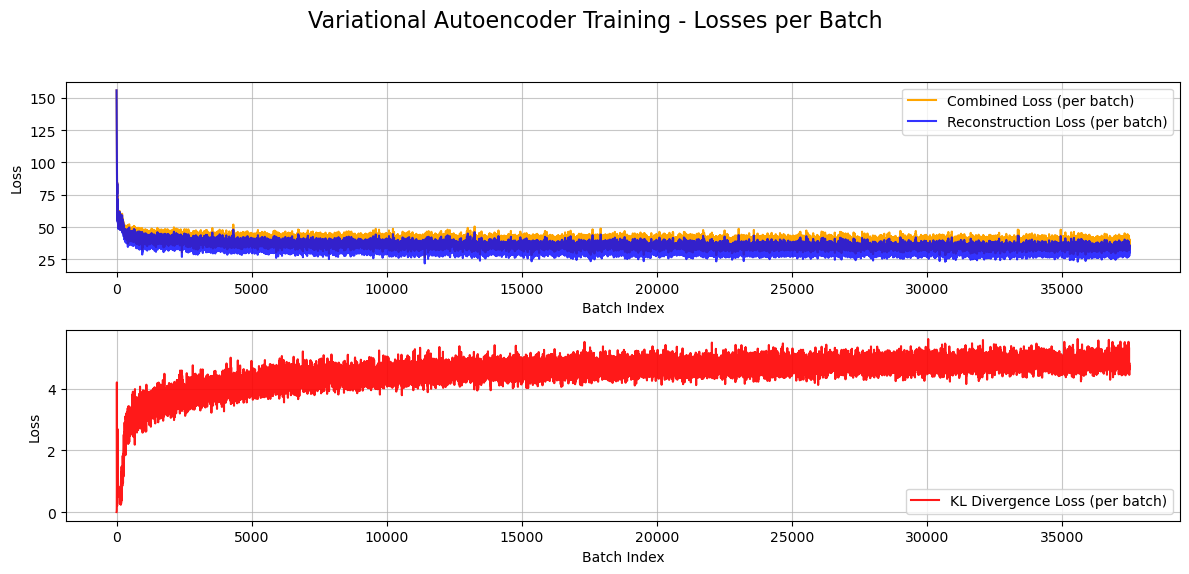

In [10]:
def plot_losses(log_dict, title):
    plt.figure(figsize=(12, 6))

    # Plot losses per batch
    plt.subplot(2, 1, 1)
    plt.plot(log_dict['train_combined_loss_per_batch'], label='Combined Loss (per batch)', color='orange', alpha=1)
    plt.plot(log_dict['train_reconstruction_loss_batch'], label='Reconstruction Loss (per batch)',linestyle='-', color='blue', alpha=0.8)
    plt.xlabel('Batch Index')
    plt.ylabel('Loss')
    #plt.title(f'{title} - Losses per Batch')
    plt.legend()
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.grid(True, linestyle='-', alpha=0.7)

    plt.subplot(2, 1, 2)
    plt.plot(log_dict['train_kl_loss'], label='KL Divergence Loss (per batch)',color='red', alpha=0.9)
    plt.xlabel('Batch Index')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()

    plt.suptitle(f'{title} - Losses per Batch', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.grid(True, linestyle='-', alpha=0.7)
    plt.show()
    
plot_losses(log_dict, 'Variational Autoencoder Training')

In [26]:
def plot_latent_spaces (classes, dataloader, encoding, device=DEVICE):
    d = {i:[] for i in range(classes)}
    with torch.no_grad():
        for i , (features, targets) in enumerate(dataloader):
            features = features.to(device)
            targets = targets.to(device)
            embedding, _, _, _ = encoding(features)

            for i in range(classes):
                if i in targets:
                    mask = targets == i
                    d[i].append(embedding[mask].to('cpu').numpy())
            
    colors = list(mcolors.TABLEAU_COLORS.items())
    for i in range(classes):
        d[i] = np.concatenate(d[i])
        plt.scatter(d[i][:,0], d[i][:,1], color=colors[i][1], label=f'{i}', alpha=0.5)
    plt.title("Latent Spaces Scatter Plot")    
    plt.grid(True)    
    plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))

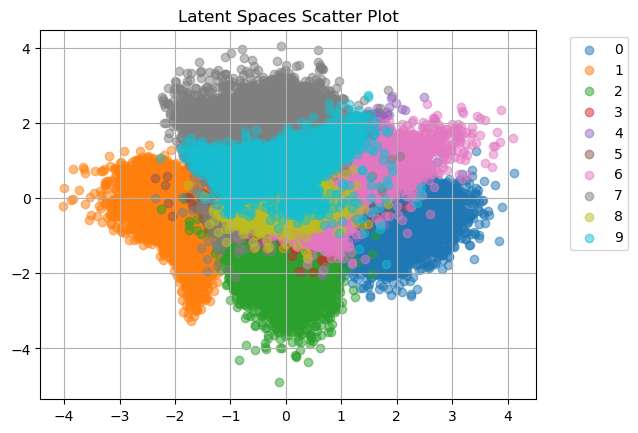

In [27]:
plot_latent_spaces(classes= 10, dataloader=train_loaders, encoding= vae.forward)

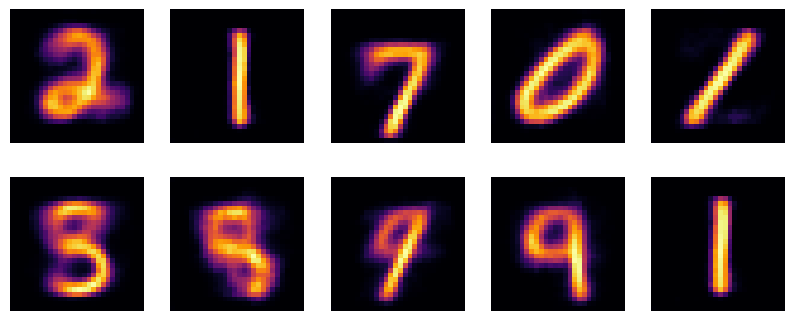

In [54]:
def generate_images(model, samples, latent_size, device=DEVICE):
    with torch.no_grad():
        z = torch.randn(samples, latent_size).to(device)
        generated_image = model.decoder(z)
    return generated_image

vae.eval()
number_of_imgs = 10
images = generate_images(model=vae, samples=number_of_imgs, latent_size=2)

plt.figure(figsize=(10, 4))
for i in range(number_of_imgs):
    plt.subplot(2, 5, i +1 )
    plt.imshow(images[i].cpu().numpy().squeeze(), cmap='inferno')
    plt.axis('off')
plt.show()